# <center>Anomaly Detection and Recommender Systems</center>

In the first half of this exercise, implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.optimize as op
from scipy import linalg
from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import f1_score
import time

## Anomaly Detection

### Implementing Anomaly Detection on an example 2D Dataset

2D Example Dataset which will help gain an intuition of how the Anomaly Detection algorithm works.

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(307, 2) (307, 2) (307, 1)


Text(0.5, 1.0, 'Example 2D data')

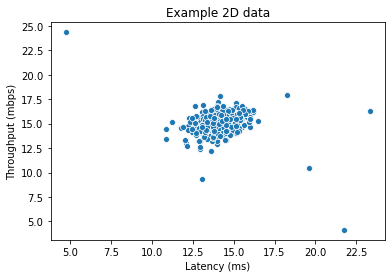

In [2]:
data2d = scipy.io.loadmat('ex8data1.mat')
print(data2d.keys())
X2d = data2d['X']
Xval2d = data2d['Xval']
yval2d = data2d['yval']
print(X2d.shape, Xval2d.shape, yval2d.shape)
fig_data11 = plt.figure()
ax_data11 = fig_data11.add_subplot(111) 
ax_data11 = sns.scatterplot(x=X2d.T[0], y=X2d.T[1])
ax_data11.set(xlabel='Latency (ms)')
ax_data11.set(ylabel='Throughput (mbps)')
ax_data11.set_title('Example 2D data')

### Gaussian Distribution

We can fit a model using Gaussian distribution shown below. We need to caculate for each feature $i = 1 ... n,$ parameters $\mu_i$ and $\sigma^2_i$
$$ p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$
For multiple variables, we can calculate the probability value for each feature and multiple all of them to get combined probability. Or we can use the Multivariate Gaussian distribution shown below
$$ p(x; \mu, \sigma^2) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2})}e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)} $$
where
$\Sigma$ is the covariance matrix and $|\Sigma|$ is its determinant

In [3]:
# Function to calculate mean and variance for a dataset
def estimateGaussian(X):
    return (np.mean(X, axis=0), np.var(X, axis=0, ddof=1))

In [4]:
# Function to calculate Multivariate Gaussian distribution
def multivarGaussian(X, mu, sigma2):
    # Library way to calcultate multivariate probability distribution
    #p = multivariate_normal.pdf(X,mu,sigma2)
    #return p
    k = mu.shape[0]
    if(sigma2.ndim == 1 or sigma2.shape[1] == 1):
        sigma2 = np.diag(sigma2)
    X = X - mu
    det = np.linalg.det(sigma2)
    si = np.linalg.inv(sigma2)
    p = np.power(2*np.pi, (-k/2)) * np.power(det, -0.5) * np.exp(-0.5 * np.sum((X.dot(si))*X, axis=1))
    return p

### Selecting Anomaly threshold using $F_1$ Score

$F_1 Score$ is a good metric to use when the dataset has very small number of positive examples and large number of negative examples. It is calculated as
$$ F_1 Score = \frac{2 * precision * recall}{precision + recall} $$
$$ precision = \frac{True Positive}{True Positive + False Positive} $$
$$ recall = \frac{True Positive}{True Positive + False Negative} $$
The threshold value which gives the highest $F_1 Score$ on cross validation data can be selected to detect anomalies

In [5]:
def getF1Score(yval, ypred):
    # Library way to calcultate F1 score
    #f1s = f1_score(yval, ypred)
    tp = np.sum(ypred[yval==1])
    fp = np.sum(ypred[yval==0])
    fn = len(ypred[yval==1]) - tp
    if tp+fp == 0:
        return 0
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1s = (2*prec*rec)/(prec+rec)
    return f1s

In [6]:
# Function to select threshold to determine anomaly
def selectThreshold(ypred_prob, yval):
    eps = 0
    besteps = 0
    bestF1 = 0
    start, stop = np.min(ypred_prob), np.max(ypred_prob)
    stepsize = (stop - start) / 1000;
    for eps in np.arange(start, stop, stepsize):
        ypred = ypred_prob<eps
        f1s = getF1Score(yval, ypred)
        if(f1s > bestF1):
            bestF1 = f1s
            besteps = eps
    return besteps

### Visualizing the fit and anomalies on 2D dataset

In [7]:
# Function to visualize contours and anomalies of the fiited Gaussian distribution
def plotGausCont(X, mu, sigma2, outliers):
    # Generate meshgrid data to plot contours for different probabilities
    xx, yy = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivarGaussian(np.c_[xx.ravel(), yy.ravel()], mu, sigma2)
    Z = Z.reshape(xx.shape)
    
    fig_data12 = plt.figure()
    ax_data12 = fig_data12.add_subplot(111) 
    # Plot actual data
    ax_data12 = sns.scatterplot(x=X.T[0], y=X.T[1], label='Data')
    # Plot contours for different probabilities
    CP = ax_data12.contour(xx, yy, Z, 10.**np.arange(-20,0,3))
    ax_data12.clabel(CP, inline=1, fontsize=10)
    print("Contour levels (Probability range):", CP.levels)
    # Highlight anomalies
    ax_data12.scatter(outliers[:, 0], outliers[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='r', label='Anomalies')
    ax_data12.legend()
    ax_data12.set(xlabel='Latency (ms)')
    ax_data12.set(ylabel='Throughput (mbps)')
    ax_data12.set_title('Example 2D data')

In [8]:
def anomalyDetect(X, Xval, yval, plot):
    # Fit model parameters - mean and variance
    (mu, sigma2) = estimateGaussian(X)
    # Calculate probability for each sample in data
    y_pred_prob = multivarGaussian(X, mu, sigma2)
    # Calculate probability for each sample in cross validation data
    # and use it to select anomaly threshold
    yval_pred_prob = multivarGaussian(Xval, mu, sigma2)
    eps = selectThreshold(yval_pred_prob, yval.ravel())
    print("Optimal anomaly threshold is", eps)
    outliers = X[y_pred_prob<eps,:]
    print("Total anomalies", outliers.shape[0])
    # Visualize
    if plot:
        plotGausCont(X, mu, sigma2, outliers)

Optimal anomaly threshold is 8.961567687193518e-05
Total anomalies 6
Contour levels (Probability range): [1.e-20 1.e-17 1.e-14 1.e-11 1.e-08 1.e-05 1.e-02]


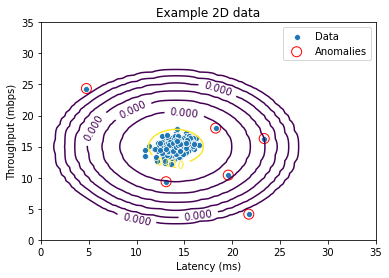

In [9]:
anomalyDetect(X2d, Xval2d, yval2d, 1)

### High Dimensional Dataset

Run anomaly detection on a more realistic dataset

In [10]:
datareal = scipy.io.loadmat('ex8data2.mat')
print(datareal.keys())
Xreal = datareal['X']
Xvalreal = datareal['Xval']
yvalreal = datareal['yval']
print(Xreal.shape, Xvalreal.shape, yvalreal.shape)
anomalyDetect(Xreal, Xvalreal, yvalreal, 0)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(1000, 11) (100, 11) (100, 1)
Optimal anomaly threshold is 1.3716606750407378e-18
Total anomalies 117


## Recommender Systems

In this part of the exercise, you will implement the collaborative filltering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and $n_m$ = 1682 movies.
You will implement the function that computes the collaborative filtlering objective and gradient. After implementing the cost function and gradient, you will use advanced optimization to learn the parameters for collaborative filtering.

### Movie Ratings Dataset

The dataset has two matrices
<br>1. Matrix Y (num_movies x num_users) which stores the ratings $y^{(i,j)}$ from 1 to 5
<br>2. Matrix R is binary-valued indicator matrix where R(i,j) = 1 if user j has rated a movie i else it is 0
<br><br>We will use two more matrices X = $ \begin{bmatrix} -(x^{(1)})^T- \\ -(x^{(2)})^T- \\. \\ -(x^{(n_m)})^T- \end{bmatrix} $ and Theta = $ \begin{bmatrix} -(\theta^{(1)})^T- \\ -(\theta^{(2)})^T- \\. \\ -(\theta^{(n_u)})^T- \end{bmatrix} $
<br>Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. We will assume each movie has n = 10 features. X is $n_m$ x 10 matrix and Theta is $n_u$ x 10 matrix

In [11]:
# Reading movie ratings dataset
movierdata = scipy.io.loadmat('ex8_movies.mat')
print(movierdata.keys())
movierY = movierdata['Y']
movierR = movierdata['R']
print(movierY.shape, movierR.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])
(1682, 943) (1682, 943)


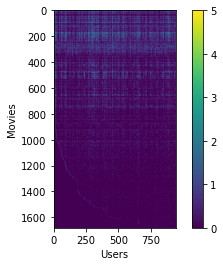

In [12]:
# Visualize the movie ratings matrix
fig_data21 = plt.figure()
ax_data21 = fig_data21.add_subplot(111) 
imY = ax_data21.imshow(movierY)
ax_data21.set(xlabel='Users')
ax_data21.set(ylabel='Movies')
fig_data21.colorbar(imY, ax=ax_data21)

In [13]:
movierparams = scipy.io.loadmat('ex8_movieParams.mat')
print(movierparams.keys())
movierX = movierparams['X']
movierT = movierparams['Theta']
movierNumUsers = movierparams['num_users'][0,0]
movierNumMovies = movierparams['num_movies'][0,0]
movierNumFeatures = movierparams['num_features'][0,0]
print(movierX.shape, movierT.shape)
print(movierNumUsers, movierNumMovies, movierNumFeatures)
tc = 0
tg = 0

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])
(1682, 10) (943, 10)
943 1682 10


### Collaborative Filtering Algorithm

We need to implement the cost function and gradient function

#### Cost Function
$$ J(x^{(1)},...,x^{(n_m)}, \theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2}\sum_{i,j:r(i,j)=1} ((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2 + R $$
where R is the Regularization term
$$ R = (\frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (\theta_k^{(j)})^2) + (\frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n (x_k^{(i)})^2) $$

In [14]:
def costfunc(TX, Y, R, l, nu, nm, nf):
    global tc
    st = time.time()
    
    # Get Theta and X
    theta = TX[:nu*nf].reshape(nu,nf)
    X = TX[nu*nf:].reshape(nm,nf)

    # Compute inner difference yhat -y
    diff = (X.dot(theta.T) - Y)
    
    # Ignore elements whose ratings are not defined 
    # by doing element-wise multiplication using r matrix
    diff = R * diff
    
    # Sum of squares of all elements and divide by
    Dr = diff.ravel()
    cost = Dr.dot(Dr.T)
    #cost = np.sum(np.sum(diff**2))
    cost /= 2
    
    # Account regularization into cost
    if l:
        Tr = theta.ravel()
        Xr = X.ravel()
        cost += (l/2 * (Tr.dot(Tr.T) + Xr.dot(Xr.T)))
        #cost += (l/2 * (np.sum(np.sum(theta**2)) + np.sum(np.sum(X**2))))
    et = time.time()
    tc += (et - st)
    return cost

In [15]:
# Test cost function on subset of data
num_users = 4; num_movies = 5; num_features = 3;
Tsub, Xsub, Ysub, Rsub = movierT[:num_users,:num_features], movierX[:num_movies,:num_features], movierY[:num_movies,:num_users], movierR[:num_movies,:num_users]
TX = np.hstack((Tsub.ravel(), Xsub.ravel()))
l = 0; c1 = costfunc(TX, Ysub, Rsub, l, num_users, num_movies, num_features)
l = 1.5; c2 = costfunc(TX, Ysub, Rsub , l, num_users, num_movies, num_features)
print("Cost without regularization {:.2f} Cost with regularization {:.2f}".format(c1, c2))

Cost without regularization 22.22 Cost with regularization 31.34


#### Gradient Function
$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} ((\theta^{(j)})^T x^{(i)} - y^{(i,j)})\theta_k^{(j)} + \lambda x_k^{(i)} $$
$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} ((\theta^{(j)})^T x^{(i)} - y^{(i,j)})x_k^{(i)} + \lambda \theta_k^{(j)} $$

In [16]:
def gradientfunc(TX, Y, R, l, nu, nm, nf):
    # Theta  - nu  x nf, X - nm   x nf, Y - nm   x nu,  R - nm   x nu
    # Theta  - 943 x 10, X - 1682 x 10, Y - 1682 x 943, R - 1682 x 943
    global tg
    st = time.time()
    
    # Get Theta and X
    theta = TX[:nu*nf].reshape(nu,nf)
    X = TX[nu*nf:].reshape(nm,nf)
    
    # Initial gradient matrices for X and Theta
    gradx = np.zeros(X.shape)
    gradt = np.zeros(theta.shape)
    
    # Compute inner difference yhat -y
    diff = (X.dot(theta.T) - Y)
    
    # Ignore elements whose ratings are not defined 
    # by doing element-wise multiplication using r matrix
    diff = R * diff
    
    # Compute gradient matrices by multiplying correspondingly
    gradx = diff.dot(theta)
    gradt = diff.T.dot(X)
    
    # Account regularization into gradient matrix
    if l:
        gradx += l * X
        gradt += l * theta
    
    et = time.time()
    tg += (et - st)
    return np.hstack((gradt.ravel(), gradx.ravel()))

#### Gradient checking (similar to Ex4 Neural Networks Backpropagation)

In [17]:
def gradientcheck(TX, Y, R, l, nu, nm, nf):
    # Compute gradient for original theta  and X parameters
    grad = gradientfunc(TX, Y, R , l, num_users, num_movies, num_features)
    # Intitialize gradient vector and epsilon as 10^-4
    gradApprox = np.zeros((TX.shape))
    epsilon = 0.0001
    # Compute cost for gradApprox, by changing one value at a time
    for i in range(TX.shape[0]):
        TXP = np.copy(TX)
        TXM = np.copy(TX)
        TXP[i] += epsilon
        TXM[i] -= epsilon
        JP = costfunc(TXP, Ysub, Rsub , l, num_users, num_movies, num_features)
        JM = costfunc(TXM, Ysub, Rsub , l, num_users, num_movies, num_features)
        gradApprox[i] = (JP - JM)/(2*epsilon)
    return (grad, gradApprox)

In [18]:
num_users = 4; num_movies = 5; num_features = 3;
Tsub, Xsub, Ysub, Rsub = movierT[:num_users,:num_features], movierX[:num_movies,:num_features], movierY[:num_movies,:num_users], movierR[:num_movies,:num_users]
TX = np.hstack((Tsub.ravel(), Xsub.ravel()))
l = 1.5;
(grad, gradApprox) = gradientcheck(TX, Ysub, Rsub, l, num_users, num_movies, num_features)
print(grad - gradApprox)

[-2.32436292e-11  8.96571706e-12  2.07389661e-12 -5.83844084e-12
  2.76434431e-11  1.77586834e-11  1.16561205e-11  1.28346223e-11
  9.86677406e-12 -1.08406617e-11  3.60012020e-12  3.46955797e-12
 -9.48552348e-12 -3.99236200e-12  1.29252165e-11 -6.07824902e-12
 -6.09912121e-12  2.23853158e-11 -5.73951997e-12  7.20845605e-12
  3.66440212e-12  1.19402821e-11 -1.42903467e-11  2.23465690e-11
 -2.10498285e-12  6.37712105e-12 -1.95431449e-11]


#### Read movie list

In [19]:
movielist = pd.read_csv('movie_ids.txt', sep="\t", header=None,encoding='latin-1')
movielist.columns = ["Index", "Movies"]
print(movielist.shape)
movielist.head()

(1682, 2)


,Index,Movies
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Add a user entry with some ratings for movies

In [20]:
# New user
my_ratings = np.zeros((movierNumMovies, 1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

# Add to Y and R matrices
Yf = np.hstack((my_ratings, movierY))
Rf = np.hstack(((my_ratings != 0), movierR))
print(Yf.shape, Rf.shape)

(1682, 944) (1682, 944)


In [21]:
# Print rated movies
print("Original ratings")
for i in range(len(my_ratings)):
    if(my_ratings[i] > 0):
        print("Rated {:.1f} for {}".format(my_ratings[i][0], movielist['Movies'][i]))

Original ratings
Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


#### Normalize ratings

In [22]:
def normalizeRatings(Y, R):
    Ynorm = np.zeros(Y.shape)
    Ymean = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        sub = R[i,:]==1
        Ymean[i] = np.mean(Y[i,sub])
        Ynorm[i,sub] = Y[i,sub] - Ymean[i]
    return (Ynorm, Ymean)

In [23]:
(Ynorm, Ymean) = normalizeRatings(Yf, Rf)
print(Ynorm.shape, Ymean.shape)

(1682, 944) (1682,)


### Learning parameters using Advanced Optimization
Use the optimization method in scipy library.

In [24]:
# Initial random values for parameters X and Theta
X_init = np.random.randn(movierNumMovies,movierNumFeatures)
T_init = np.random.randn(movierNumUsers+1,movierNumFeatures)
print(X_init.shape, T_init.shape)

(1682, 10) (944, 10)


In [25]:
l = 10
TX = np.hstack((T_init.ravel(), X_init.ravel()))
tc = tg = 0
st = time.time()
Result = op.minimize(fun = costfunc, 
                         x0 = TX, 
                         args = (Ynorm, Rf, l, movierNumUsers+1, movierNumMovies, movierNumFeatures),
                         method = 'CG',
                         jac = gradientfunc,
                        options = {'maxiter': 100});
et = time.time()
optimal_tx = Result.x;
initcost = costfunc(TX, Ynorm, Rf, l, movierNumUsers+1, movierNumMovies, movierNumFeatures)
finalcost = costfunc(optimal_tx, Ynorm, Rf, l, movierNumUsers+1, movierNumMovies, movierNumFeatures)
print("Time take to optimize", (et-st))
print("Total Time take to calculate cost", tc)
print("Total Time take to calculate gradient", tg)
print("Initial Cost {:.2f} Final cost {:.2f}".format(initcost, finalcost))

optimal_theta = optimal_tx[:(movierNumUsers+1)*movierNumFeatures].reshape(movierNumUsers+1,movierNumFeatures)
optimal_X = optimal_tx[(movierNumUsers+1)*movierNumFeatures:].reshape(movierNumMovies,movierNumFeatures)

Time take to optimize 7.598676919937134
Total Time take to calculate cost 3.6133697032928467
Total Time take to calculate gradient 3.6185343265533447
Initial Cost 672196.61 Final cost 38980.00


### Top Movie Recommendations

In [26]:
yhat = optimal_X.dot(optimal_theta.T)
my_predictions = yhat[:,0] + Ymean
# Get the indices of weights sorted weights
p_sort = np.argsort(my_predictions)
# Get descended sorted copy
p_rsort = p_sort[::-1]
print("Top recommendations for you")
for i in range(10):
    ind = p_rsort[i]
    print("Predicted rating {:.1f} for {}".format(my_predictions[ind], movielist['Movies'][ind]))

Top recommendations for you
Predicted rating 5.0 for Great Day in Harlem, A (1994)
Predicted rating 5.0 for Aiqing wansui (1994)
Predicted rating 5.0 for Someone Else's America (1995)
Predicted rating 5.0 for Entertaining Angels: The Dorothy Day Story (1996)
Predicted rating 5.0 for Prefontaine (1997)
Predicted rating 5.0 for They Made Me a Criminal (1939)
Predicted rating 5.0 for Marlene Dietrich: Shadow and Light (1996) 
Predicted rating 5.0 for Star Kid (1997)
Predicted rating 5.0 for Saint of Fort Washington, The (1993)
Predicted rating 5.0 for Santa with Muscles (1996)
